In [119]:
import plotly.express as px
import pandas as pd
import numpy as np
import fairlearn
np.__version__, fairlearn.__version__
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.utils import resample
import tensorflow as tf

# In-processing
from aif360.datasets import StandardDataset


# Métriques
from aif360.sklearn.metrics import *
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# Introduction NIH Chest X-Rays

Ce dataset vient de : 
https://www.kaggle.com/datasets/nih-chest-xrays/data

C'est un dataset qui contient des données sur des images X-Rays et leurs patients,

Les radiographies thoraciques font partie des examens d'imagerie médicale les plus fréquents et les plus rentables. Cependant, le diagnostic clinique à partir d'une radiographie thoracique peut être complexe. 
L'absence de grands ensembles de données publics avec des annotations rend encore très difficile, l'obtention de systèmes de détection et de diagnostic assistés par ordinateur cliniquement pertinents.

Le but de se projet serait donc d'entrainer un modele pour reconnaitre les maladies presentes dans les radiographies du dataset.

les colonnes plus pertinentes sont:
 - Finding Labels : 15 labels, 14 indiquant des maladies et 1 indiquant l'absence des maladies
 - Follow-up # : le nombre de fois que ce patient revient faire des X-rays
 - Patient Age
 - Patient Gender 
 - View Position : Position dans laquelle l'image a été prise

Le reste des données (sauf le Patient ID seront effacés car on considere qu'elles ne sont pas pertinents).

Dans le contexte de ce Projet on analysera uniquement 55174 lignes de ce dataset, et on traitera principalement l'analyse prealablé de ces données et des techniques de pre-processing pour reduire les biais possibles.

In [42]:
mydata = pd.read_csv('LEIVA_MARTIN/metadata.csv')

#On enleve des metadonnées des images qui ne sint pas utiles
mydata= mydata.drop(columns=[
                             'OriginalImage[Width','Height]',
                             'OriginalImagePixelSpacing[x','y]',
                             ])

#On voit des lignes avec des gens ayant plus de 120 ans , meme 414 ans!
#On a decidé de les eliminer
mydata = mydata[mydata['Patient Age'] <= 115]

#Ici on cherche a separer les maladies par colonne
conditions_encoded = mydata['Finding Labels'].str.get_dummies(sep='|')
mydata = mydata.drop(columns=['Finding Labels'])
mydata = pd.concat([mydata, conditions_encoded], axis=1)
mydata['Patient Gender'] = mydata['Patient Gender'].map({'M': 0, 'F': 1})
mydata['View Position'] = mydata['View Position'].map({'PA': 0, 'AP': 1})


In [43]:

maladies = conditions_encoded.columns

maladie_counts = [mydata[maladie].sum() for maladie in maladies]

maladies_with_counts = {}

i = 0
for maladie in maladies:
    maladies_with_counts[maladie] = maladie_counts[i]
    i += 1


# Creation des subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=["Follow Up", "Age", "Gender", "View Position"])

# On ajoute 4 Subplots
fig.add_trace(go.Box(x=mydata['Follow-up #'], name='Follow ups'), row=1, col=1)
fig.add_trace(go.Box(x=mydata['Patient Age'], name='Age'), row=1, col=2)
fig.add_trace(go.Histogram(x=mydata['Patient Gender'], name='Gender'), row=2, col=1)
fig.add_trace(go.Histogram(x=mydata['View Position'], name='View Position'), row=2, col=2)

#Barplot sur les images par maladie
fig2 = go.Figure(
    data = [go.Bar ( x = maladies, y = maladie_counts, text = maladie_counts, textposition='auto' )],
    layout_title_text = "Nombre de radiographies par maladie",
)


fig.update_layout(title="Plots des données")
fig.show()
fig2.show()

# Analyse des données

## Follow-up :

On remarque une quantité assez grande d'outliers :

    Q1 : 0
    Médiane : 3
    Q3 : 10

## Âge :
 
L'individu le plus jeune a 1 an et le plus âgé a 95 ans.
Nous avons décidé de limiter l'âge à 115 ans (le record mondial), car nous avons trouvé un individu âgé de plus de 400 ans.

    Q1 : 34
    Médiane : 49
    Q3 : 60

## Genre :

On remarque que les genres ne sont pas déséquilibrés de façon significative ; cependant, les hommes sont majoritaires.
Position de vue :

On remarque qu'il y a une différence d’environ 10 000 images entre les positions PA et AP :

    AP : Avant vers arrière
    PA : Arrière vers avant

## Maladies :

En ce qui concerne les maladies, c'est l'aspect où l'on observe le plus de déséquilibre.

Notamment, on remarque que No Finding est énormément sur-représenté avec environ 29 000 occurrences, tandis que Hernia et Pneumonia sont sous-représentés avec respectivement 126 et 718 occurrences.

Afin de mieux visualiser les écarts entre les maladies et les autres données, nous allons raisonner en pourcentages.

In [44]:
from IPython.display import Markdown, display
import numpy as np

heading = "#####"
md_output = "# Difference par rapport à la moyenne:\n"


# Calculer la proportion de chaque maladie
moyenne_par_maladie = [mydata[maladie].mean() for maladie in maladies]

# Calculer la moyenne des proportions
overall_average = np.mean(moyenne_par_maladie)

# Calculer l'écart type pour chaque maladie
ecarts_types = [mydata[maladie].std() for maladie in maladies]

# Ajouter les différences par rapport à la moyenne
for i, maladie in enumerate(maladies):
    difference = (moyenne_par_maladie[i] - overall_average) * 100
    md_output += f"{heading} - **{maladie}**: {difference:.2f}% (Écart type: {ecarts_types[i]:.4f})\n"

# Ajouter les autres pourcentages
md_output += "\n# Autres pourcentages:\n"
md_output += f"- Pourcentage d'images etant des **Femmes**: {sum((mydata['Patient Gender'] == 'F')/len(mydata))*100 : .2f}%\n"
md_output += f"- Pourcentage d'images etant des **Hommes**: {sum((mydata['Patient Gender'] == 'M')/len(mydata))*100 : .2f}%\n"
md_output += f"- Pourcentage d'images en vue **PA**: {sum((mydata['View Position'] == 'PA')/len(mydata))*100 : .2f}%\n"
md_output += f"- Pourcentage d'images en vue **AP**: {sum((mydata['View Position'] == 'AP')/len(mydata))*100 : .2f}%\n"

# Afficher le résultat en Markdown

md_output += ''' \n On confirme bien ce qu'on voit dans le graphique. Les conditions sont severement desequibrés, Notamment No Findings qui est 45% plus presente que la moyenne,
l 'ecart type est utile pour comprendre la distribution des maladies et pour identifier celles qui ont des occurrences plus prévisibles ou plus variables.
Des écarts types faibles suggèrent que la maladie est présente de manière relativement constante parmi les patients'''
display(Markdown(md_output))

# Difference par rapport à la moyenne:
##### - **Atelectasis**: 1.82% (Écart type: 0.3050)
##### - **Cardiomegaly**: -5.87% (Écart type: 0.1618)
##### - **Consolidation**: -4.38% (Écart type: 0.2001)
##### - **Edema**: -6.40% (Écart type: 0.1453)
##### - **Effusion**: 5.05% (Écart type: 0.3428)
##### - **Emphysema**: -6.00% (Écart type: 0.1577)
##### - **Fibrosis**: -7.10% (Écart type: 0.1198)
##### - **Hernia**: -8.47% (Écart type: 0.0293)
##### - **Infiltration**: 9.26% (Écart type: 0.3827)
##### - **Mass**: -2.90% (Écart type: 0.2310)
##### - **No Finding**: 43.26% (Écart type: 0.4997)
##### - **Nodule**: -1.84% (Écart type: 0.2503)
##### - **Pleural_Thickening**: -5.51% (Écart type: 0.1719)
##### - **Pneumonia**: -7.32% (Écart type: 0.1104)
##### - **Pneumothorax**: -3.61% (Écart type: 0.2169)

# Autres pourcentages:
- Pourcentage d'images etant des **Femmes**:  0.00%
- Pourcentage d'images etant des **Hommes**:  0.00%
- Pourcentage d'images en vue **PA**:  0.00%
- Pourcentage d'images en vue **AP**:  0.00%
 
 On confirme bien ce qu'on voit dans le graphique. Les conditions sont severement desequibrés, Notamment No Findings qui est 45% plus presente que la moyenne,
l 'ecart type est utile pour comprendre la distribution des maladies et pour identifier celles qui ont des occurrences plus prévisibles ou plus variables.
Des écarts types faibles suggèrent que la maladie est présente de manière relativement constante parmi les patients

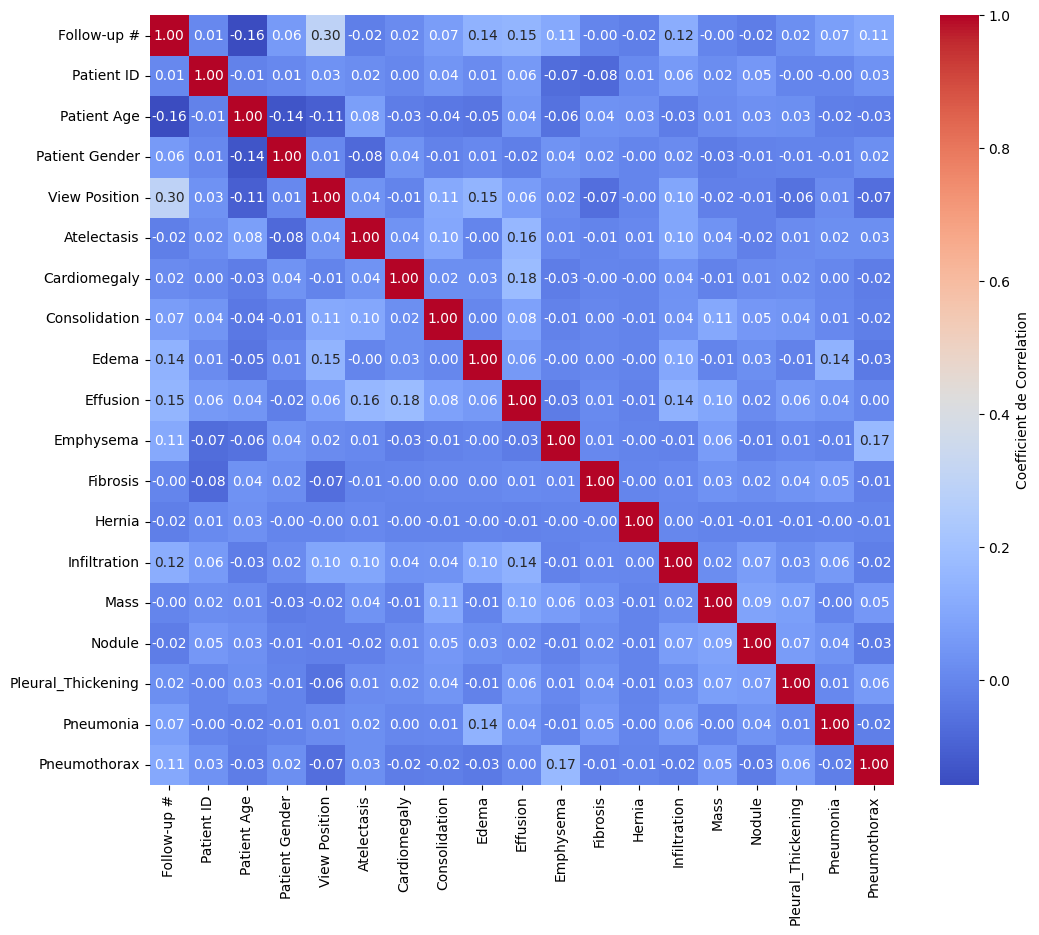

In [45]:
# Encodage des variables categoriques
data_corr = mydata.copy(deep=True)
data_corr = data_corr.drop(columns= ['No Finding', 'Image Index', 'WEIGHTS'])

correlation_matrix = data_corr.corr()

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Coefficient de Correlation'})
plt.show()


# Analyse des coorelations

## - Follow Up:

On remarque quelles maladies ont besoin d'un nombre plus grande de radiographies: 
Dans l'ordre decroissant on a : Edema (0.16) , Infiltratioin (0.13) , Cardiomegaly et Pleural Thickening (0.12)

On a aussi un coefficient de 0.32 entre Follow-up et View position, ce qui peut indiquer que si le nombre de follow ups augmente on a un peu plus de tendance a avoir des radiographies AP

## - Patient Age:

Il n'y a pas des correlatioiins fortes entre l'age et les maladies dans ce dataset, la correlatiion la plus forte serait avec Hernia (0.22) qui impliquerait que les personnes agées ont plus tendance a etre susceptibles.

## - Patient Gender:

Le genre n'a pas des correlations fortes entre les maladies

## - View Position
On voit quelques correlations faibles avec les maladies suivantes :
Consolidation, Edema, Infiltration et Pneuomonia

## - Maladies

On constate que la plupart des maladies ne sont pas correllées entre-elles, c'est a dire qu'elles ne se chevauchent pas dans le dataset (on n'a pas souvent deux maladies).

Cependant il y a quelques correlations remarquables:

Ceci n'est pas un avis medical, je ne suis pas medecin et c'est le resultat d'une recherche rapide sur google

- **Cardiomegaly et Effusion (0.13)**:
    Cardiomegaly correspond a un coeur elargi et l'effusion correspond a l'accumulation de fluides, qui pourrait enlargir le coeur

- **Edema et Pneumonia (0.28)**:
    Pneumonia est une maladie qui provoque l'accumulation des fluides dans les poumons, et Edema est une autre maladie qui fait reference a l'acumulation des fluides

- **Emphysema et Pneumothorax (0.24)**:
    Pneumothorax correspond a  l'effondrement des poumons, certaines variations d'Emphysema peuvent provoquer ces effondrements.

Il faut rappeller aussi que ces correlations sont faibles ( < 0.3), et leur utilité pour le modele n'est pas forcement claire. 

# Pre-traitement des données:

Afin de re-equilibrer les maladies j'ai crée deux approches differents, un a travers du resampling et un autre avec du reweighting

## Resampling:
    Le resampling consiste a soit effacer ou generer/dupliquer des données pour reequilibrer la quantite d'apparitions entre maladies, a la base je voulais utiliser SMOTE pour generer des données plus pertinentes mais ceci c'est averé difficile a implementer:

    l'approche est donc la suivante, eliminer des entrées au hasard des conditions sur-representées et effacer des entrées au hasard des conditions sur-representées

### Avantages

- **Facile a utiliser** 

- **Efficace pour les classes déséquilibrées** : Permet de montrer davantage d’exemples de la classe minoritaire (sur-échantillonnage) ou de réduire l’impact trop important de la classe majoritaire (sous-échantillonnage).  

- **Flexibilité** : Des méthodes comme SMOTE, ADASYN ou autres variations du sur-échantillonnage peuvent générer des exemples synthétiques pour la classe minoritaire, préservant mieux la diversité des données qu’un simple duplicata. ( Ce n'est pas mon cas)


### Inconvénients

- **Sur-apprentissage possible (sur-échantillonnage)** : Dupliquer simplement les échantillons minoritaires peut amener le modèle à trop mémoriser ces exemples spécifiques.  

- **Perte de données (sous-échantillonnage)** : Supprimer des échantillons de la classe majoritaire revient à jeter potentiellement des informations précieuses, ce qui diminue la taille du jeu de données.  

- **Temps d’entraînement plus long (sur-échantillonnage)** : L’augmentation du nombre d’exemples peut accroître la charge de calcul durant l’entraînement.

In [46]:


def resample_label_to_n_samples(data, label, n_samples, random_state=123):
    """
    Resample le dataset pour que le label aille exactement  n_samples.

    Parametres:
    - data: dataset a resample.
    - label: label a resample.
    - n_samples: nombre de samples attendus pour le label indiqué.
    - random_state: Graine random.
    
    Renvoie:
    - resampled_data: dataframe apres resample
    """

    df_positive = data[data[label] == 1]  
    df_negative = data[data[label] == 0]  

    if len(df_positive) < n_samples:
        df_positive_resampled = resample(df_positive,
                                         replace=True,         
                                         n_samples=n_samples,
                                         random_state=random_state)
    else:
        df_positive_resampled = resample(df_positive,
                                         replace=False,        
                                         n_samples=n_samples,
                                         random_state=random_state)

    resampled_data = pd.concat([df_negative, df_positive_resampled])
    resampled_data = resampled_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
    return resampled_data



''' 
L'idée ici est de rapprocher les apparitions de chaque condition de la moyenne,
on utilise le scaling factor pour dire a quel point on veut l'approcher a la moyenne
de plus on a le tableau overrepresented pour ajuster le scaling factor pour les classes qui
sont vraiment eloignées de la moyenne
'''

counts = list(maladies_with_counts.values())
average_count = np.mean(counts)
scaling_factor = 0.35
target_counts = {}
for label, current_count in maladies_with_counts.items():
    target_count = int(current_count + scaling_factor * (average_count - current_count))
    target_counts[label] = target_count
    #print(f"Label: {label}, Current count: {current_count}, Target count: {target_count}")


overrepresented = [ 'No Finding','Effusion', 'Atelectasis','Infiltration']
features_columns = ['Follow-up #', 'Patient Age', 'Patient Gender', 'View Position']
data_resampled = mydata.copy()

for label in maladies_with_counts.keys():
    #print(f"\label: {label}")
    if label in overrepresented:
        if label == 'No Finding':
            sf = 0.3
        else:
            sf = 0.6

        target_count = int(target_counts[label]*sf) 

    else:
        target_count = target_counts[label] 

    current_count = maladies_with_counts[label]
    #print(f"Current count: {current_count}, Target count: {target_count}")
    data_resampled = resample_label_to_n_samples(
        data=data_resampled,
        label=label,
        n_samples= target_count,
        random_state=123
    )
    
    # Mettre a jour les counts
    maladies_with_counts[label] = data_resampled[data_resampled[label] == 1].shape[0]
    


In [47]:


maladies = conditions_encoded.columns

maladie_counts = [data_resampled[maladie].sum() for maladie in maladies]

# Creation des subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=["Follow Up", "Age", "Gender", "View Position"])

# On ajoute 4 Subplots
fig.add_trace(go.Box(x=data_resampled['Follow-up #'], name='Follow ups'), row=1, col=1)
fig.add_trace(go.Box(x=data_resampled['Patient Age'], name='Age'), row=1, col=2)
fig.add_trace(go.Histogram(x=data_resampled['Patient Gender'], name='Gender'), row=2, col=1)
fig.add_trace(go.Histogram(x=data_resampled['View Position'], name='View Position'), row=2, col=2)

#Barplot sur les images par maladie
fig2 = go.Figure(
    data = [go.Bar ( x = maladies, y = maladie_counts, text = maladie_counts, textposition='auto' )],
    layout_title_text = "Nombre d'images par maladie",
)


fig.update_layout(title="Plots des données")
fig.show()
fig2.show()

## Reweighting 
Le reweighting consiste a rajouter a chaque condition un poids correspondant a sa representatoion dans le dataset, Ici on utilise 3 methodes differentes:

Objectif : Accorder plus d'importance aux classes minoritaires pour améliorer l'apprentissage du modèle.



### Avantages

- **Pas de copie ou de suppression de données** : Préserve la totalité des données initiales, évitant ainsi les problèmes liés à la suppression (sous-échantillonnage) ou à la duplication (sur-échantillonnage).  

- **Facile à mettre en place dans de nombreux algorithmes** : De nombreuses bibliothèques de machine learning proposent des paramètres pour spécifier les poids des classes (par exemple, `class_weight` dans scikit-learn).  

- **Moins de risque de sur-apprentissage** : Étant donné que les points de données ne sont pas dupliqués, il y a moins de risques de mémorisation excessive des exemples de la classe minoritaire.


### Inconvénients

- **Compatibilité limitée** : Tous les modèles ou librairies ne prennent pas nécessairement en charge la gestion de poids, surtout dans les solutions plus anciennes ou spécialisées.  

- **Instabilité numérique possible** : Des poids trop grands ou trop petits peuvent rendre l’entraînement et l’optimisation plus instables, en particulier dans les réseaux de neurones.  

In [48]:


# Définir les tranches d'âge (0-9, 10-19, ..., 90-99, 100+)
bins = list(range(0, 101, 10))  
age_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
mydata['Age Group'] = pd.cut(mydata['Patient Age'], bins=bins, labels=age_labels, right=False)


#Ceci est utilisé dans les 3 methodes
gender_counts = mydata['Patient Gender'].value_counts()
vp_counts = mydata['View Position'].value_counts()
age_counts = mydata['Age Group'].value_counts()

# Median Frequency Balancing
Formule:

$$w_i = \frac{\text{fréquence médiane}}{\text{freq}(i)}$$

où la fréquence médiane est la médiane des fréquences de toutes les classes.

### Avantages :

Moins extrême que la fréquence inverse (évite les poids trop élevés).

Assure qu’aucune classe ne reçoit un poids excessivement bas.

Fonctionne bien pour des jeux de données avec un déséquilibre modéré.

### Inconvénients :

Ne gère pas bien les classes très rares (car dépend de la médiane).

Moins efficace que ENS pour les distributions très déséquilibrées.

### Meilleurs cas d’utilisation :

Classification multi-classes avec un déséquilibre modéré.

Données médicales et biologiques, où certaines classes sont naturellement sous-représentées.

In [49]:
#MFB Gender, View Position, Age

median_frequency_pg = np.median(gender_counts.values)
median_frequency_vp = np.median(vp_counts.values)
median_frequency_age = np.median(age_counts.values)

weights_pg = gender_counts.apply(lambda freq: median_frequency_pg / freq)
weights_vp = vp_counts.apply(lambda freq: median_frequency_vp / freq)
weights_age = age_counts.apply(lambda freq: median_frequency_age / freq)


# Normalisation des poids (normalisation par la somme des poids)
total_weight_pg = weights_pg.sum()
total_weight_vp = weights_vp.sum()
total_weight_age = weights_age.sum()

# Normalisation
normalized_weights_pg = weights_pg / total_weight_pg
normalized_weights_vp = weights_vp / total_weight_vp
normalized_weights_age = weights_age / total_weight_age

# Appliquer les poids normalisés
mydata['Gender_MFB_weight'] = mydata['Patient Gender'].map(normalized_weights_pg)
mydata['VP_MFB_weight'] = mydata['View Position'].map(normalized_weights_vp)
mydata['Age_MFB_weight'] = mydata['Age Group'].map(normalized_weights_age)




# Effective Number of Samples
Formule :

$$w_i = \frac{1 - \beta^{n_i}}{1 - \beta}$$

où :

$n_i$​ = nombre d’échantillons dans la classe ,

$\beta$ = facteur de lissage (typiquement 0,99 ou 0,999).

### Avantages :

Ajuste les poids de manière progressive, évitant les valeurs extrêmes.

Contrôle la pondération des classes rares grâce au paramètre β.

Fonctionne bien lorsque la distribution des classes est fortement déséquilibrée.


### Inconvénients :

Nécessite de régler l’hyperparamètre β.

Plus complexe à calculer que la fréquence inverse.

### Meilleurs cas d’utilisation :

Problèmes de classification avec une distribution très déséquilibrée (ex. imagerie médicale, vision par ordinateur, NLP).

Données hiérarchiques, où certaines catégories apparaissent naturellement moins souvent.

In [50]:
#ENS Gender
beta = 0.9999


# Calcul des poids EN
def calculate_en_weight(count, beta):
    return (1 - beta) / (1 - beta ** count)

# Number of  samples

gender_weights = {gender: calculate_en_weight(count, beta) for gender, count in gender_counts.items()}
vp_weights = {vp: calculate_en_weight(count, beta) for vp, count in vp_counts.items()}
age_weights = {age_group: calculate_en_weight(count, beta) for age_group, count in age_counts.items()}


#Normalisation
total_weight_gender = sum(gender_weights.values())
normalized_gender_weights = {gender: weight / total_weight_gender for gender, weight in gender_weights.items()}

total_weight_vp = sum(vp_weights.values())
normalized_vp_weights = {vp: weight / total_weight_vp for vp, weight in vp_weights.items()}

total_weight_age = sum(age_weights.values())
normalized_age_weights = {age_group: weight / total_weight_age for age_group, weight in age_weights.items()}


#Appliquer au data Frame
mydata['Gender_ENS_weight'] = mydata['Patient Gender'].map(normalized_gender_weights)
mydata['VP_ENS_weight'] = mydata['View Position'].map(normalized_vp_weights)
mydata['Age_ENS_weight'] = mydata['Age Group'].map(normalized_age_weights)

# Inverse class frequency
Formule :
    $$w_i = 1 / freq(i)$$

où freq(i) est le nombre d’occurrences de la classe i.

### Avantages :

Simple et facile à mettre en œuvre.

Fonctionne bien lorsque les fréquences des classes sont très différentes.

Aide à gérer des déséquilibres de classe importants.

### Inconvénients :
Peut conduire à une surcompensation des classes rares, rendant l’entraînement instable.

Les classes très minoritaires reçoivent des poids extrêmement élevés, ce qui peut provoquer du surapprentissage.

Ne prend pas en compte la difficulté d’apprentissage d’une classe.

### Meilleurs cas d’utilisation :

Classification binaire et multi-classes avec un fort déséquilibre des classes.

Situations où les classes sous-représentées doivent avoir plus d’importance.

In [82]:
#ICF Gender
# Calcul des poids inverses basés sur la fréquence
gender_weights = {gender: 1.0 / count for gender, count in gender_counts.items()}
vp_weights = {vp: 1.0 / count for vp, count in vp_counts.items()}
age_weights = {age_group: 1.0 / count for age_group, count in age_counts.items()}

# Normalisation
total_weight_gender = sum(gender_weights.values())
normalized_gender_weights = {gender: weight / total_weight_gender for gender, weight in gender_weights.items()}

total_weight_icf = sum(vp_weights.values())
normalized_vp_weights = {vp: weight / total_weight_icf for vp, weight in vp_weights.items()}

total_weight_age = sum(age_weights.values())
normalized_age_weights = {age_group: weight / total_weight_age for age_group, weight in age_weights.items()}

#Appliquer Poids
mydata['Gender_ICF_weight'] = mydata['Patient Gender'].map(normalized_gender_weights)
mydata['VP_ICF_weight'] = mydata['View Position'].map(normalized_vp_weights)
mydata['Age_ICF_weight'] = mydata['Age Group'].map(normalized_age_weights)



# Post-Processing

On cherche à connaître à quel point le modele incrémente les biais, on a pris 3 paramètres importants:
- View Position
- Age (On a divisée en tranches de 10 ans)
- Gender

Puis on a calculé les poids avec les méthodes:
- Inverse class frequency
- Effective number of samples 
- Median Frequency balancing

On cherche donc à analyser quelques metriques intéressantes. Pour ça, on utilisera: 
- Precision
- Recall
- F1 Score
pour chaque paramètre afin de verifier s'il y a un biais et comment le modele reagit en fonction


In [179]:
suffix = ['Gender_', 'VP_','Age_']
methods = [ 'MFB', 'ENS', 'ICF']
fichiers = ['./expe_log/WEIGHTS.csv'] #On garde le poids par defaut pour voir les biais du modele:
datasets = {}

#On construit tous les chemins
for s in suffix:
    for m in methods:
        fichiers.append(f"./expe_log/{s}{m}_weight.csv")

#On transforme tout en valeurs numeriques
binary_mapping = {"malade": 1, "sain": 0}
age_mappings = {}
for i in range(0,len(age_labels)):
    age_mappings[age_labels[i]] = i

#On construit la liste des datasets
for fichier in fichiers:
    dataset = pd.read_csv(fichier)
    dataset.drop(columns=['Image Index'], inplace = True)
    dataset["preds"] = dataset["preds"].map(binary_mapping)
    dataset["labels"] = dataset["labels"].map(binary_mapping)
    dataset["Age Group"] = dataset["Age Group"].map(age_mappings)
    datasets[fichier] = dataset

In [192]:
privileged_groups = [{'Patient Gender': 0}]
unprivileged_groups = [{'Patient Gender': 1}]

aif_datasets = {}

for fichier, dataset in datasets.items():
    datasetf = StandardDataset(
        dataset,
        label_name='labels',               
        favorable_classes=[1],              
        protected_attribute_names=['Patient Gender','Age Group'], 
        privileged_classes=[[1]]       
    )
    aif_datasets[fichier] = datasetf

print(aif_datasets['./expe_log/Age_ENS_weight.csv'])


               instance weights    features                         \
                                                                     
                                Follow-up # Patient ID Patient Age   
instance names                                                       
0                           1.0         0.0        6.0        81.0   
1                           1.0         0.0       14.0        61.0   
2                           1.0         0.0       15.0        70.0   
3                           1.0         0.0       29.0        59.0   
4                           1.0         0.0       34.0        74.0   
...                         ...         ...        ...         ...   
5833                        1.0         0.0    30703.0        58.0   
5834                        1.0         1.0    30703.0        58.0   
5835                        1.0         0.0    30722.0        45.0   
5836                        1.0         0.0    30795.0        53.0   
5837                

In [ ]:
fichier = "./expe_log/WEIGHTS.csv"

base_rate = BinaryLabelDatasetMetric(aif_datasets[fichier], unprivileged_groups=[{"Patient Gender": 1}], privileged_groups=[{"Patient Gender": 0}]).base_rate()
print(f"{fichier.split('/')[-1].replace('.csv', '')}: {base_rate}")


consistency = BinaryLabelDatasetMetric(aif_datasets[fichier], unprivileged_groups=[{"Patient Gender": 1}], privileged_groups=[{"Patient Gender": 0}]).consistency()
print(f"{fichier.split('/')[-1].replace('.csv', '')}: {consistency}")

mean_difference = BinaryLabelDatasetMetric(aif_datasets[fichier], unprivileged_groups=[{"Patient Gender": 1}], privileged_groups=[{"Patient Gender": 0}]).mean_difference()
print(f"{fichier.split('/')[-1].replace('.csv', '')}: {mean_difference}")

md_output = ""



#CES METRIQUES SONT PEUT ETRE INUTILES
for age_group in range(10):

    base_rate = BinaryLabelDatasetMetric(aif_datasets[fichier], unprivileged_groups=[{"Age Group": age_group}], privileged_groups=[{"Age Group": age_group + 2}]).base_rate()
    md_output += f"### Base Rate for Age Group {age_group}: {base_rate}\n"
    
    consistency = BinaryLabelDatasetMetric(aif_datasets[fichier], unprivileged_groups=[{"Age Group": age_group}], privileged_groups=[{"Age Group": age_group + 1}]).consistency()
    md_output += f"**Consistency for Age Group {age_group}: {consistency}**\n\n"
    
  
    mean_difference = BinaryLabelDatasetMetric(aif_datasets[fichier], unprivileged_groups=[{"Age Group": age_group}], privileged_groups=[{"Age Group": age_group + 1}]).mean_difference()
    md_output += f"**Mean Difference for Age Group {age_group}: {mean_difference}**\n\n"

# Display the output
display(Markdown(md_output))

WEIGHTS: 0.48184309695101063
WEIGHTS: [0.70006852]
WEIGHTS: -0.014052667062823598


c:\Users\barto\Code Repos\Fairness\Fenv\Lib\site-packages\aif360\metrics\binary_label_dataset_metric.py:105: RuntimeWarning:

invalid value encountered in scalar divide



### Base Rate for Age Group 0: 0.48184309695101063
**Consistency for Age Group 0: [0.70006852]**

**Mean Difference for Age Group 0: -0.10843655059593366**

### Base Rate for Age Group 1: 0.48184309695101063
**Consistency for Age Group 1: [0.70006852]**

**Mean Difference for Age Group 1: 0.06505097065862958**

### Base Rate for Age Group 2: 0.48184309695101063
**Consistency for Age Group 2: [0.70006852]**

**Mean Difference for Age Group 2: 0.06332073065184712**

### Base Rate for Age Group 3: 0.48184309695101063
**Consistency for Age Group 3: [0.70006852]**

**Mean Difference for Age Group 3: 0.00799225460575198**

### Base Rate for Age Group 4: 0.48184309695101063
**Consistency for Age Group 4: [0.70006852]**

**Mean Difference for Age Group 4: -0.06031005535000389**

### Base Rate for Age Group 5: 0.48184309695101063
**Consistency for Age Group 5: [0.70006852]**

**Mean Difference for Age Group 5: -0.021437403790344922**

### Base Rate for Age Group 6: 0.48184309695101063
**Consistency for Age Group 6: [0.70006852]**

**Mean Difference for Age Group 6: 0.017181629272309318**

### Base Rate for Age Group 7: 0.48184309695101063
**Consistency for Age Group 7: [0.70006852]**

**Mean Difference for Age Group 7: -0.196316120906801**

### Base Rate for Age Group 8: 0.48184309695101063
**Consistency for Age Group 8: [0.70006852]**

**Mean Difference for Age Group 8: -0.1925**

### Base Rate for Age Group 9: 0.48184309695101063
**Consistency for Age Group 9: [0.70006852]**

**Mean Difference for Age Group 9: nan**



In [161]:
md_output = "## Disparate Impact Ratio en fonction du genre\n"

gender = list(datasets.items())[:4]
for fichier, df  in dict(gender).items():
    di_ratio = disparate_impact_ratio(
        y_true=df['labels'],
        y_pred=df['preds'], 
        prot_attr=df['Patient Gender'], 
        priv_group= 0,  
        pos_label=0        
    )
    
    md_output += f"**{fichier.split('/')[-1].replace('.csv', '')}**:  {di_ratio:.3f}%\n\n"

md_output += "## Disparate Impact Ratio en fonction de l'age\n"

age = list(datasets.items())[:1] + list(datasets.items())[-3:] 
for fichier, df in dict(age).items():
    privileged_group = 3
    di_ratio = disparate_impact_ratio(
        y_true=df['labels'],
        y_pred=df['preds'], 
        prot_attr=df['Age Group'],  
        priv_group=privileged_group,  
        pos_label=1        
    )
    
    md_output += f"**{fichier.split('/')[-1].replace('.csv', '')}**: {di_ratio:.3f}%\n\n"

md_output += "## Equal Opportunity Difference en fonction du genre\n"

gender = list(datasets.items())[:4]
for fichier, df  in dict(gender).items():
    eod = equal_opportunity_difference(
        y_true=df['labels'],
        y_pred=df['preds'], 
        prot_attr=df['Patient Gender'], 
        priv_group= 0,  
        pos_label=0        
    )
    
    md_output += f"**{fichier.split('/')[-1].replace('.csv', '')}**:  {eod:.3f}%\n\n"

md_output += "## Equal Opportunity Difference en fonction de l'age\n"

age = list(datasets.items())[:1] + list(datasets.items())[-3:] 
for fichier, df in dict(age).items():
    privileged_group = 8
    eod = equal_opportunity_difference(
        y_true=df['labels'],
        y_pred=df['preds'], 
        prot_attr=df['Age Group'],  
        priv_group=privileged_group,  
        pos_label=1      
    )
    
    md_output += f"**{fichier.split('/')[-1].replace('.csv', '')}**: {eod:.3f}%\n\n"

md_output += "## Average Odds Difference en fonction du genre\n"

gender = list(datasets.items())[:4]
for fichier, df  in dict(gender).items():
    aod = average_odds_difference(
        y_true=df['labels'],
        y_pred=df['preds'], 
        prot_attr=df['Patient Gender'], 
        priv_group= 0,  
        pos_label=0        
    )
    
    md_output += f"**{fichier.split('/')[-1].replace('.csv', '')}**:  {aod:.3f}%\n\n"

md_output += "## Average Odds Difference en fonction de l'age\n"

age = list(datasets.items())[:1] + list(datasets.items())[-3:] 
for fichier, df in dict(age).items():
    privileged_group = 8
    aod = average_odds_difference(
        y_true=df['labels'],
        y_pred=df['preds'], 
        prot_attr=df['Age Group'],  
        priv_group=privileged_group,  
        pos_label=1      
    )
    
    md_output += f"**{fichier.split('/')[-1].replace('.csv', '')}**: {aod:.3f}%\n\n"



display(Markdown(md_output))

## Disparate Impact Ratio en fonction du genre
**WEIGHTS**:  0.920%

**Gender_MFB_weight**:  0.959%

**Gender_ENS_weight**:  1.337%

**Gender_ICF_weight**:  0.877%

## Disparate Impact Ratio en fonction de l'age
**WEIGHTS**: 1.101%

**Age_MFB_weight**: 1.104%

**Age_ENS_weight**: 1.109%

**Age_ICF_weight**: 1.069%

## Equal Opportunity Difference en fonction du genre
**WEIGHTS**:  -0.059%

**Gender_MFB_weight**:  -0.020%

**Gender_ENS_weight**:  0.150%

**Gender_ICF_weight**:  -0.075%

## Equal Opportunity Difference en fonction de l'age
**WEIGHTS**: -0.214%

**Age_MFB_weight**: -0.219%

**Age_ENS_weight**: -0.235%

**Age_ICF_weight**: -0.521%

## Average Odds Difference en fonction du genre
**WEIGHTS**:  -0.043%

**Gender_MFB_weight**:  -0.027%

**Gender_ENS_weight**:  0.136%

**Gender_ICF_weight**:  -0.067%

## Average Odds Difference en fonction de l'age
**WEIGHTS**: -0.307%

**Age_MFB_weight**: -0.105%

**Age_ENS_weight**: -0.275%

**Age_ICF_weight**: -0.387%



### EXPLICACION DE YODA, CAMBIAR

Fairness Metrics Recap: How They Work and What They Measure

When evaluating fairness in machine learning, especially in sensitive domains like medical diagnosis using X-rays, it is important to ensure that the model does not disproportionately benefit or harm certain groups. Below is a recap of three key fairness metrics:
1️⃣ Disparate Impact Ratio (DI)

🔹 What it Measures:

    DI compares the selection rates (how often a group is predicted as positive) between an unprivileged and privileged group.

    It is a measure of demographic parity and checks whether a protected group is getting positive outcomes at the same rate as the privileged group.

🔹 Formula:
DI=P(Y^=1∣unprivileged group)P(Y^=1∣privileged group)
DI=P(Y^=1∣privileged group)P(Y^=1∣unprivileged group)​

Where:

    P(Y^=1)P(Y^=1) is the probability of being classified as positive.

🔹 Interpretation:
✅ DI = 1 → Perfect fairness (both groups have equal selection rates).
⚠ DI < 1 → Unprivileged group is disadvantaged (lower positive outcome rate).
⚠ DI > 1 → Privileged group is disadvantaged (higher positive outcome rate).

🔹 Example:

    If DI = 0.8, the unprivileged group has an 80% chance of receiving a positive outcome compared to the privileged group.

    If DI = 0.5, the unprivileged group is severely disadvantaged.

    Regulatory thresholds often consider DI below 0.8 as a sign of bias.

2️⃣ Equal Opportunity Difference (EOD)

🔹 What it Measures:

    EOD focuses on true positive rates (TPR) between unprivileged and privileged groups.

    It ensures equal recall across groups, meaning that both groups should have an equal chance of being correctly identified as positive.

🔹 Formula:
EOD=TPRunprivileged−TPRprivileged
EOD=TPRunprivileged​−TPRprivileged​

Where:

    TPR=TPTP+FNTPR=TP+FNTP​ (True Positive Rate, also called recall).

🔹 Interpretation:
✅ EOD = 0 → Perfect fairness (both groups have equal recall).
⚠ EOD > 0 → Unprivileged group benefits (higher recall than privileged).
⚠ EOD < 0 → Privileged group benefits (higher recall than unprivileged).

🔹 Example:

    If EOD = -0.2, it means the privileged group has a 20% higher recall than the unprivileged group.

    This suggests that the model is missing more positive cases for the unprivileged group.

🔹 Why it Matters in Medical Context?

    In medical diagnosis, a negative EOD means the privileged group is getting diagnosed more accurately than the unprivileged group, leading to potential underdiagnosis in the unprivileged group.

3️⃣ Average Odds Difference (AOD)

🔹 What it Measures:

    AOD is a more comprehensive metric that looks at both TPR and False Positive Rate (FPR).

    It ensures that both detection rates and false alarm rates are fair across groups.

🔹 Formula:
AOD=(TPRunprivileged−TPRprivileged)+(FPRunprivileged−FPRprivileged)2
AOD=2(TPRunprivileged​−TPRprivileged​)+(FPRunprivileged​−FPRprivileged​)​

Where:

    FPR=FPFP+TNFPR=FP+TNFP​ (False Positive Rate).

🔹 Interpretation:
✅ AOD = 0 → Perfect fairness (both groups have equal TPR and FPR).
⚠ AOD > 0 → Unprivileged group benefits (higher recall & lower false alarms).
⚠ AOD < 0 → Privileged group benefits (better recall & lower false alarms).

🔹 Example:

    If AOD = -0.15, the privileged group has a 15% advantage in detection and misclassification rates.

    If AOD = 0.05, the unprivileged group is slightly favored.

🔹 Why it Matters in Medical Context?

    A negative AOD means the model detects disease better for the privileged group and possibly misdiagnoses more cases in the unprivileged group.

    This can lead to worse health outcomes for the unprivileged group.

In [167]:
from sklearn.metrics import confusion_matrix

def calcul_tpr_fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    # flat le confusion matrix en array 1D
    tn, fp, fn, tp = cm.ravel()

    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0  
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  

    return tpr, fpr

md_output = "### Calcul de TPR et FPR en fonction du genre \n"
md_output += "| Genre | TPR | FPR |\n"
md_output += "|-------|-----|-----|\n"  

for gender in [0, 1]:  # 0 pour hommes, 1 pour femmes
    df_gender = df[df['Patient Gender'] == gender]  # Filter by gender
    tpr_gender, fpr_gender = calcul_tpr_fpr(df_gender['labels'], df_gender['preds'])
    gender_label = "Hommes" if gender == 0 else "Femmes"
    # Add data to table with formatting to 4 decimal places
    md_output += f"| {gender_label} | {tpr_gender:.4f} | {fpr_gender:.4f} |\n"

md_output += "### Calcul de TPR et FPR en fonction de l'âge \n"
md_output += "| Groupe d'Age | TPR | FPR |\n"
md_output += "|--------------|-----|-----|\n"  


for age_group in range(10):  
    df_age = df[df['Age Group'] == age_group]  # Filter by age group
    tpr_age, fpr_age = calcul_tpr_fpr(df_age['labels'], df_age['preds'])
    md_output += f"| {age_labels[age_group]} | {tpr_age:.4f} | {fpr_age:.4f} |\n"



display(Markdown(md_output))

### Calcul de TPR et FPR en fonction du genre 
| Genre | TPR | FPR |
|-------|-----|-----|
| Hommes | 0.4519 | 0.1653 |
| Femmes | 0.3699 | 0.1249 |
### Calcul de TPR et FPR en fonction de l'âge 
| Groupe d'Age | TPR | FPR |
|--------------|-----|-----|
| 0-9 | 0.4857 | 0.0238 |
| 10-19 | 0.3470 | 0.1529 |
| 20-29 | 0.3823 | 0.1264 |
| 30-39 | 0.4529 | 0.1168 |
| 40-49 | 0.2906 | 0.1017 |
| 50-59 | 0.4013 | 0.1427 |
| 60-69 | 0.4608 | 0.2199 |
| 70-79 | 0.6103 | 0.2871 |
| 80-89 | 0.9318 | 0.4000 |
| 90-99 | 0.9545 | 0.0000 |


Le TPR (True Positive Rate) et le FPR (False Positive Rate) sont deux métriques importantes utilisées pour évaluer la performance d'un modèle de classification, en particulier lorsqu'il s'agit de mesurer la qualité des prédictions dans des contextes où les classes sont déséquilibrées ou lorsque l'on souhaite analyser les erreurs du modèle en fonction de sous-groupes.
1. True Positive Rate (TPR) ou Sensibilité / Rappel / Recall

Le TPR, également appelé rappel, mesure la capacité du modèle à correctement identifier les exemples positifs parmi tous les exemples réellement positifs.

La formule pour calculer le TPR est la suivante :
TPR=TPTP+FN
TPR=TP+FNTP​

Où :

    TP (True Positives) : Nombre de vrais positifs (exemples correctement classés comme positifs).

    FN (False Negatives) : Nombre de faux négatifs (exemples positifs mal classés comme négatifs).

Interprétation du TPR :

    Un TPR élevé (proche de 1) signifie que le modèle identifie bien les exemples positifs, c'est-à-dire qu'il a peu de faux négatifs.

    Un TPR faible (proche de 0) signifie que le modèle manque une grande proportion des exemples positifs (beaucoup de faux négatifs).

Exemple pour le genre :

Si le modèle prédit correctement un grand nombre de femmes malades parmi toutes les femmes malades, le TPR pour les femmes sera élevé. En revanche, si beaucoup de femmes malades sont mal classées comme négatives, le TPR pour les femmes sera faible.
2. False Positive Rate (FPR) ou Taux de Faux Positifs

Le FPR mesure la proportion d'exemples négatifs qui sont incorrectement classés comme positifs. Autrement dit, c'est la fraction d'exemples négatifs qui sont mal classés comme positifs.

La formule pour calculer le FPR est la suivante :
FPR=FPFP+TN
FPR=FP+TNFP​

Où :

    FP (False Positives) : Nombre de faux positifs (exemples négatifs mal classés comme positifs).

    TN (True Negatives) : Nombre de vrais négatifs (exemples correctement classés comme négatifs).

Interprétation du FPR :

    Un FPR faible (proche de 0) signifie que le modèle fait peu d'erreurs en classant des exemples négatifs comme positifs (c'est-à-dire qu'il a une faible proportion de faux positifs).

    Un FPR élevé (proche de 1) signifie que le modèle classifie trop souvent des exemples négatifs comme positifs (beaucoup de faux positifs).

Exemple pour l'âge :

Si, pour un certain groupe d'âge, le modèle prédit à tort que des patients non malades sont malades (faux positifs), le FPR pour ce groupe d'âge sera élevé. Si au contraire, il prédit correctement un grand nombre de personnes non malades comme non malades, le FPR sera faible.
Résumé de l'Interprétation :

    TPR élevé signifie que le modèle fait bien son travail pour détecter les exemples positifs (peu de faux négatifs).

    FPR faible signifie que le modèle fait peu d'erreurs en identifiant des exemples négatifs comme positifs (peu de faux positifs).

TPR et FPR dans le Contexte des Sous-groupes :

Lorsque vous évaluez le TPR et le FPR sur différents groupes de données (par exemple, sur le genre ou l'âge), cela permet d'analyser l'équité du modèle pour chaque groupe :

    Si le TPR est significativement plus bas pour un groupe par rapport à un autre, cela peut indiquer que le modèle a des difficultés à détecter les exemples positifs dans ce groupe.

    Si le FPR est plus élevé pour un groupe, cela signifie que le modèle est plus susceptible de faire des erreurs en classifiant des exemples négatifs comme positifs dans ce groupe.

En résumé, le TPR est une mesure de la capacité du modèle à ne pas manquer des exemples positifs, tandis que le FPR est une mesure de la tendance du modèle à identifier à tort des exemples négatifs comme positifs. Les deux métriques sont particulièrement utiles dans les analyses de biais et d'équité, car elles permettent de vérifier si le modèle se comporte de manière équitable pour tous les groupes de données.
